<a href="https://colab.research.google.com/github/MatheusAcacioR/collab-notebook-human-activity-recognization/blob/main/HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importações
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [ ]:
# mapa de cores personalizado utilizado para alguns gráficos
custom_cmap = matplotlib.colors.ListedColormap(["#94d2bdff", "#72c3b4ff", "#4fb3aaff", "#2da3a0ff", "#0a9396ff", "#057985ff", "#005f73ff", "#004f5fff", "#003f4bff", "#002932ff"])

pallete: https://coolors.co/94d2bd-72c3b4-4fb3aa-2da3a0-0a9396-057985-005f73-004f5f-003f4b-002932

In [ ]:
#funções utilizadas
def removePositions():
  global positions, positionsLabelsHistoric

  # subtrair arrays
  for a in positionsLabelsHistoric: 
    if a in positions: 
      positions.remove(a)

def addPositions():
  for a in positionsLabelsHistoric: 
    if a in positions: 
      positions.append(a)

def NewPositionSameLabel():
  global positions, positionsLabelsHistoric
  
  # transformando as posições da label que estao em tupla para lista
  positions = positionsCurrentCopyYTest[0].tolist()

  # subtrair arrays
  removePositions()

def newPredictionNewLabel():
  global newYtest, lock, formerLabel, labels, currentRandomLabel, positionsCurrentCopyYTest, positions, newPositionLabel, positionsLabelsHistoric, formerPrediction, currentPrediction, FP, TN

  positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

  positions = positionsCurrentCopyYTest[0].tolist()

  addPositions()

  newPositionLabel = random.choice(positions)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    FP = FP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(1)
  else:
    TN = TN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(1)
    
  labels.append(formerLabel)

def newPredictionSameLabel():
  global newYtest, lock, formerLabel, labels, currentRandomLabel, positionsCurrentCopyYTest, positions, newPositionLabel, positionsLabelsHistoric, formerPrediction, currentPrediction, TP, FN

  positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

  positions = positionsCurrentCopyYTest[0].tolist()

  addPositions()

  newPositionLabel = random.choice(positions)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    TP = TP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(0)
  else:
    FN = FN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
    newYtest.append(0)

def uniqueLabel():
  global positionsCurrentCopyYTest, positions, positionsLabelsHistoric, newPositionLabel, formerPrediction, currentPrediction, FP, TN, TP, FN
  
  positionsCurrentCopyYTest = np.where(copyY_test == labels[0])

  positions = positionsCurrentCopyYTest[0].tolist()

  # subtrair arrays
  removePositions()

  newPositionLabel = random.choice(positions)
  positionsLabelsHistoric.append(newPositionLabel)

  formerPrediction = currentPrediction

  currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
  if currentPrediction == formerPrediction:
    FP = FP + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])
  else:
    TN = TN + 1
    trues.append(formerPrediction[0])
    predictions.append(currentPrediction[0])


  for positionLabel in positions:
    formerPrediction = currentPrediction

    currentPrediction = knn.predict(copyX_test[positionLabel].reshape(1, -1))
    if currentPrediction == formerPrediction:
      TP = TP + 1
      trues.append(formerPrediction[0])
      predictions.append(currentPrediction[0])
    else:
      FN = FN + 1
      trues.append(formerPrediction[0])
      predictions.append(currentPrediction[0])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=custom_cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# obtendo os parametros para multi-classe
def perf_measure(y_actual, y_hat):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [ ]:
# dataframe
df = pd.read_csv("https://raw.githubusercontent.com/zhangzhao156/Human-Activity-Recognition-Codes-Datasets/master/data/SanitationDataset/sanitation.csv")

In [ ]:
df

,x,y,z,label,seg,suspicious
0,20,781,-507,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
1,40,797,-492,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
2,59,807,-502,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
3,75,807,-527,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
4,107,806,-560,walk,walk/863137003295439_walk_L_2017-07-25 17-39-0...,False
...,...,...,...,...,...,...
266550,-941,174,337,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266551,-942,173,314,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266552,-916,158,310,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False
266553,-898,145,304,clean,clean/庆喜/repeat_82-duration_60.csv-1584-1628,False


In [ ]:
# armazenando os valores de label
labelsName = df["label"].unique()

In [ ]:
# dataframe que ira armazenar os valores das features dos calculadas
df_trat = pd.DataFrame()

In [ ]:
# tempo de execução médio do código: 9 minutos
# for de iteração de cada label do dataframe
for lb in range(0, len(labelsName)):
  # tratando os dados: separando as linhas de cada label, split do ultimo numero da janela, retirando a coluna antiga da janela e inserindo a nova, armazenando os valores de cada janela
  dfSplited = df[df["label"] == labelsName[lb]]
  lastNDfSplited = dfSplited["seg"].squeeze()
  lastNDfSplited = lastNDfSplited.str.rsplit("-", n=1, expand=True)
  lastNDfSplited.rename(columns={0: 'seg', 1: 'random'}, inplace=True)
  dfSplited = dfSplited.drop(columns=['seg'])
  dfSplited = pd.concat([dfSplited, lastNDfSplited], axis=1)
  dfSplited = dfSplited[['x', 'y', 'z', 'label', 'seg', 'random', 'suspicious']]
  windowsDfSplited = dfSplited["random"].unique()

  cont = 0

  # for de iteração de cada janela de cada label do dataframe
  for window in range(len(df_trat), len(df_trat) + len(windowsDfSplited)):
    # calculando as features: maximo, minimo, binomial, media, mediana, variancia, desvp, mad
    df_trat.loc[window, 'maxX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.max()
    df_trat.loc[window, 'minX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.min()
    df_trat.loc[window, 'binX'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].x.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].x.min()) / 10
    df_trat.loc[window, 'medX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.mean()
    df_trat.loc[window, 'mediX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.median()
    df_trat.loc[window, 'varX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.var()
    df_trat.loc[window, 'desvX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.std()
    df_trat.loc[window, 'madX'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].x.mad()

    df_trat.loc[window, 'maxY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.max()
    df_trat.loc[window, 'minY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.min()
    df_trat.loc[window, 'binnY'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].y.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].y.min()) / 10
    df_trat.loc[window, 'medY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.mean()
    df_trat.loc[window, 'mediY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.median()
    df_trat.loc[window, 'varY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.var()
    df_trat.loc[window, 'desvY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.std()
    df_trat.loc[window, 'madY'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].y.mad()

    df_trat.loc[window, 'maxZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.max()
    df_trat.loc[window, 'minZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.min()
    df_trat.loc[window, 'binZ'] = (dfSplited[dfSplited.random == windowsDfSplited[cont]].z.max() - dfSplited[dfSplited.random == windowsDfSplited[cont]].z.min()) / 10
    df_trat.loc[window, 'medZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.mean()
    df_trat.loc[window, 'mediZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.median()
    df_trat.loc[window, 'varZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.var()
    df_trat.loc[window, 'desvZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.std()
    df_trat.loc[window, 'madZ'] = dfSplited[dfSplited.random == windowsDfSplited[cont]].z.mad()

    cont+=1

df_trat

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,desvY,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ
0,143.0,-128.0,27.1,-42.970588,-77.0,6320.655838,79.502552,68.980104,896.0,696.0,...,41.808334,33.126298,-460.0,-691.0,23.1,-536.161765,-531.0,2895.421203,53.809118,43.117215
1,-88.0,-143.0,5.5,-109.395349,-105.0,246.339978,15.695221,13.482964,961.0,843.0,...,32.402183,28.484586,-159.0,-445.0,28.6,-312.511628,-322.0,8310.589147,91.162433,80.174148
2,15.0,-61.0,7.6,-24.238095,-30.0,319.795587,17.882829,15.204082,1006.0,951.0,...,12.633515,9.793651,-10.0,-134.0,12.4,-52.738095,-40.5,1344.783391,36.671288,31.379819
3,-59.0,-160.0,10.1,-120.176471,-128.0,559.550483,23.654819,20.008651,1016.0,851.0,...,36.453378,28.766003,-58.0,-455.0,39.7,-213.500000,-186.5,9542.522388,97.685835,83.250000
4,1053.0,-130.0,118.3,517.697674,631.0,215070.930233,463.757405,431.114116,772.0,77.0,...,170.741533,139.366144,137.0,-835.0,97.2,-473.325581,-577.0,94687.796235,307.713822,269.156301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,737.0,621.0,11.6,681.467742,679.0,431.597303,20.774920,16.239854,371.0,271.0,...,24.780138,20.555671,729.0,619.0,11.0,673.370968,679.0,912.302750,30.204350,26.528616
4390,804.0,661.0,14.3,730.326531,734.0,1335.016156,36.537873,30.211579,421.0,288.0,...,40.599797,35.099542,700.0,518.0,18.2,599.265306,588.0,3028.698980,55.033617,46.202416
4391,1078.0,404.0,67.4,756.268293,763.0,23795.501220,154.257905,104.638905,428.0,-146.0,...,141.282868,112.424747,794.0,315.0,47.9,623.268293,646.0,10985.351220,104.811026,71.633551
4392,1126.0,581.0,54.5,771.577465,757.0,7817.676056,88.417623,47.450506,465.0,35.0,...,74.628971,50.536005,726.0,396.0,33.0,598.732394,611.0,4019.170221,63.396926,42.271771


In [ ]:
df_trat

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,desvY,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ
0,143.0,-128.0,27.1,-42.970588,-77.0,6320.655838,79.502552,68.980104,896.0,696.0,...,41.808334,33.126298,-460.0,-691.0,23.1,-536.161765,-531.0,2895.421203,53.809118,43.117215
1,-88.0,-143.0,5.5,-109.395349,-105.0,246.339978,15.695221,13.482964,961.0,843.0,...,32.402183,28.484586,-159.0,-445.0,28.6,-312.511628,-322.0,8310.589147,91.162433,80.174148
2,15.0,-61.0,7.6,-24.238095,-30.0,319.795587,17.882829,15.204082,1006.0,951.0,...,12.633515,9.793651,-10.0,-134.0,12.4,-52.738095,-40.5,1344.783391,36.671288,31.379819
3,-59.0,-160.0,10.1,-120.176471,-128.0,559.550483,23.654819,20.008651,1016.0,851.0,...,36.453378,28.766003,-58.0,-455.0,39.7,-213.500000,-186.5,9542.522388,97.685835,83.250000
4,1053.0,-130.0,118.3,517.697674,631.0,215070.930233,463.757405,431.114116,772.0,77.0,...,170.741533,139.366144,137.0,-835.0,97.2,-473.325581,-577.0,94687.796235,307.713822,269.156301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,737.0,621.0,11.6,681.467742,679.0,431.597303,20.774920,16.239854,371.0,271.0,...,24.780138,20.555671,729.0,619.0,11.0,673.370968,679.0,912.302750,30.204350,26.528616
4390,804.0,661.0,14.3,730.326531,734.0,1335.016156,36.537873,30.211579,421.0,288.0,...,40.599797,35.099542,700.0,518.0,18.2,599.265306,588.0,3028.698980,55.033617,46.202416
4391,1078.0,404.0,67.4,756.268293,763.0,23795.501220,154.257905,104.638905,428.0,-146.0,...,141.282868,112.424747,794.0,315.0,47.9,623.268293,646.0,10985.351220,104.811026,71.633551
4392,1126.0,581.0,54.5,771.577465,757.0,7817.676056,88.417623,47.450506,465.0,35.0,...,74.628971,50.536005,726.0,396.0,33.0,598.732394,611.0,4019.170221,63.396926,42.271771


In [ ]:
# nomeando a coluna label com as respectivas labels das linhas do dataframe das features
df_trat.loc[0:170, 'label'] = 'walk'
df_trat.loc[171:1423, 'label'] = 'bweep' 
df_trat.loc[1424:2007, 'label'] = 'clean'
df_trat.loc[2008:2970, 'label'] = 'sweep' 
df_trat.loc[2971:3840, 'label'] = 'daily'
df_trat.loc[3841:4316, 'label'] = 'dump'
df_trat.loc[4317:4393, 'label'] = 'run'

In [ ]:
# arredondando os valores das features
df_trat = df_trat.round(2)

bweep = 0
clean = 1
daily = 2
dump = 3
run = 4
sweep = 5
walk = 6

In [ ]:
df_trat["label"] = df_trat["label"].astype('category')
df_trat["label"] = df_trat["label"].cat.codes

In [ ]:
# embaralhando os dados
df_shuffled = df_trat.sample(frac=1).reset_index(drop=True)
df_shuffled

,maxX,minX,binX,medX,mediX,varX,desvX,madX,maxY,minY,...,madY,maxZ,minZ,binZ,medZ,mediZ,varZ,desvZ,madZ,label
0,1221.0,-62.0,128.3,440.49,407.0,67783.51,260.35,190.38,1790.0,-443.0,...,547.48,800.0,-1268.0,206.8,-426.55,-505.0,288648.75,537.26,427.23,0
1,1427.0,-252.0,167.9,619.08,646.5,212028.43,460.47,381.61,1746.0,-48.0,...,326.34,1202.0,-989.0,219.1,-79.87,-143.0,261039.69,510.92,392.52,2
2,65.0,-926.0,99.1,-378.25,-245.0,89874.89,299.79,268.53,1181.0,-178.0,...,363.68,290.0,-1191.0,148.1,-298.91,20.5,267865.48,517.56,481.42,3
3,-166.0,-1706.0,154.0,-875.16,-777.0,180787.62,425.19,352.37,525.0,-11.0,...,86.92,-66.0,-806.0,74.0,-486.26,-481.0,44224.24,210.30,171.24,5
4,-377.0,-1821.0,144.4,-867.51,-768.0,150232.97,387.60,310.01,742.0,-37.0,...,152.89,408.0,-730.0,113.8,-263.79,-246.0,59365.69,243.65,177.68,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,-266.0,-1865.0,159.9,-910.47,-882.0,133010.56,364.71,292.01,867.0,-307.0,...,259.85,1105.0,135.0,97.0,576.13,567.0,42717.04,206.68,158.93,0
4390,667.0,29.0,63.8,337.26,305.0,37857.88,194.57,169.41,1428.0,291.0,...,286.21,133.0,-958.0,109.1,-358.11,-346.0,59970.17,244.89,180.04,0
4391,1707.0,-522.0,222.9,360.84,239.0,330857.86,575.20,460.24,1755.0,-198.0,...,345.64,633.0,-1202.0,183.5,-359.23,-440.5,246917.02,496.91,419.16,0
4392,-559.0,-1219.0,66.0,-892.11,-879.0,25108.10,158.46,126.79,616.0,-56.0,...,118.32,58.0,-705.0,76.3,-368.89,-368.0,30730.78,175.30,137.53,5


In [ ]:
df_input = df_shuffled.iloc[:,0:23]
df_output = df_shuffled.iloc[:,24]
X = df_input.values
Y = df_output.values

In [ ]:
smt = SMOTE()

In [ ]:
X, Y = smt.fit_resample(X, Y)

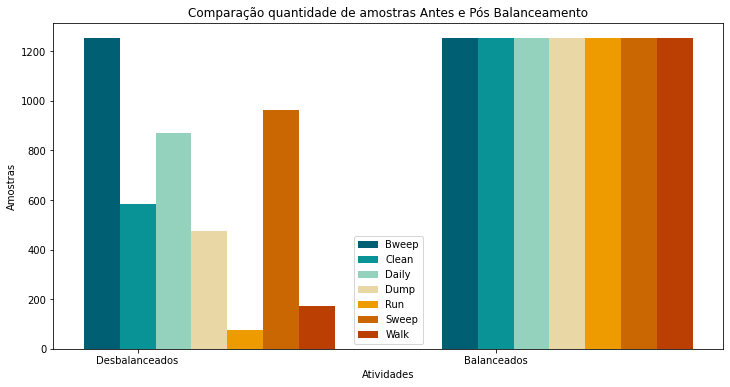

In [ ]:
#Quantidades
qtd0 = [len(df_trat[df_trat["label"] == 0]), len(X[Y == 0])]
qtd1 = [len(df_trat[df_trat["label"] == 1]), len(X[Y == 1])]
qtd2 = [len(df_trat[df_trat["label"] == 2]), len(X[Y == 2])]
qtd3 = [len(df_trat[df_trat["label"] == 3]), len(X[Y == 3])]
qtd4 = [len(df_trat[df_trat["label"] == 4]), len(X[Y == 4])]
qtd5 = [len(df_trat[df_trat["label"] == 5]), len(X[Y == 5])]
qtd6 = [len(df_trat[df_trat["label"] == 6]), len(X[Y == 6])]

# Tamanho das barras
barWidth = 0.1

# Tamanho da figura
plt.figure(figsize=(12,6))

# Posição das barras
r0 = np.arange(len(qtd0))
r1 = [x + barWidth for x in r0]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Criando as barras
plt.bar(r0, qtd0, color="#005f73", width=barWidth, label="Bweep")
plt.bar(r1, qtd1, color="#0a9396", width=barWidth, label="Clean")
plt.bar(r2, qtd2, color="#94d2bd", width=barWidth, label="Daily")
plt.bar(r3, qtd3, color="#e9d8a6", width=barWidth, label="Dump")
plt.bar(r4, qtd4, color="#ee9b00", width=barWidth, label="Run")
plt.bar(r5, qtd5, color="#ca6702", width=barWidth, label="Sweep")
plt.bar(r6, qtd6, color="#bb3e03", width=barWidth, label="Walk")

# Adicionando legenda as barras
plt.xlabel('Atividades')
plt.xticks([r + barWidth for r in range(len(qtd0))], ['Desbalanceados', 'Balanceados'])
plt.ylabel('Amostras')
plt.title('Comparação quantidade de amostras Antes e Pós Balanceamento')

# Legenda e exibindo o gráfico
plt.legend()
plt.show()

pallet: https://coolors.co/001219-005f73-0a9396-94d2bd-e9d8a6-ee9b00-ca6702-bb3e03-ae2012-9b2226

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=5)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
labels = df_shuffled["label"].unique()

In [ ]:
labelsName.sort()
labels.sort()

# KNN

## Teste do algoritmo

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

In [ ]:
# treinando o modelo
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# predição dos valores do conjunto de teste
y_pred = knn.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision Test:",metrics.precision_score(y_test,y_pred))
# print("Recall Test:",metrics.recall_score(y_test,y_pred))

Accuracy: 0.9312310030395137


In [ ]:
f1_score(y_test, y_pred, average='weighted') 

0.9312995630376318

In [ ]:
labels = df_shuffled["label"].unique()

In [ ]:
labelsName.sort()
labels.sort()

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       354
           1       0.90      0.88      0.89       384
           2       0.94      0.90      0.92       402
           3       0.94      0.94      0.94       379
           4       0.97      0.99      0.98       377
           5       0.96      0.94      0.95       375
           6       0.96      0.97      0.96       361

    accuracy                           0.93      2632
   macro avg       0.93      0.93      0.93      2632
weighted avg       0.93      0.93      0.93      2632

Confusion matrix, without normalization
[[316  18   5   5   0   8   2]
 [ 24 339   8   6   3   3   1]
 [ 12  19 360   3   2   2   4]
 [  9   0   3 358   1   3   5]
 [  0   0   0   0 375   0   2]
 [ 14   1   0   6   0 353   1]
 [  0   0   6   1   4   0 350]]


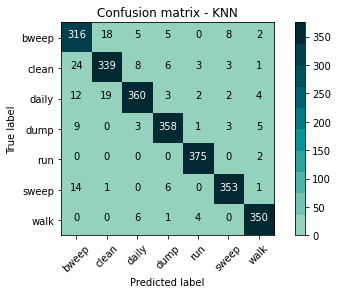

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - KNN')

In [ ]:
teste = perf_measure(y_test, y_pred)

In [ ]:
teste

({0, 1, 2, 3, 4, 5, 6},
 [316, 339, 360, 358, 375, 353, 350],
 [59, 38, 22, 21, 10, 16, 15],
 [2135, 2112, 2091, 2093, 2076, 2098, 2101],
 [122, 143, 159, 160, 171, 165, 166])

In [ ]:
print(teste[2])
print(teste[4])

[59, 38, 22, 21, 10, 16, 15]
[122, 143, 159, 160, 171, 165, 166]


In [ ]:
fp = int(sum(teste[2])/7)
fn = int(sum(teste[4])/7)


print(fp)
print(fn)

25
155


In [ ]:
accuracys = []

# Calculating error for K values between 1 and 10
for i in range(1, 10):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    accuracys.append(metrics.accuracy_score(y_test, pred_i))

In [ ]:
accuracys

[0.9460486322188449,
 0.9331306990881459,
 0.9300911854103343,
 0.9312310030395137,
 0.9278115501519757,
 0.9274316109422492,
 0.9217325227963525,
 0.9205927051671733,
 0.9183130699088146]

Text(0, 0.5, 'Accuracy')

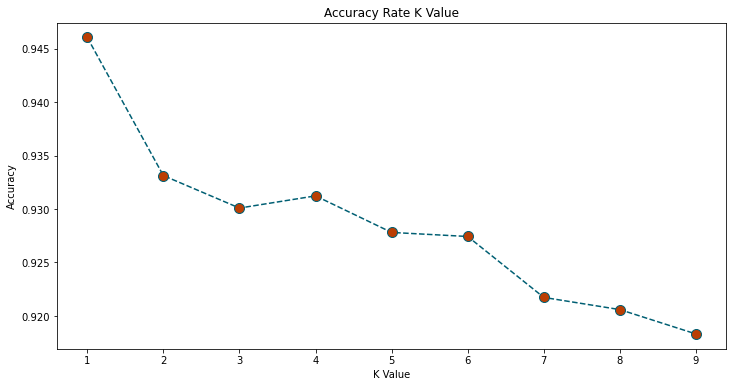

In [ ]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 10), accuracys, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('Accuracy Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy')

In [ ]:
# validação cruzada
num_folds = 5
scores = cross_val_score(knn, X_train, y_train, cv = num_folds)

In [ ]:
scores

array([0.89, 0.89, 0.89, 0.9 , 0.88])

In [ ]:
for v in scores:
  print(v)

0.8900651465798045
0.8916938110749185
0.8900651465798045
0.9030944625407166
0.882640586797066


In [ ]:
stdevCross = scores.std()
stdevCross

0.006589009568774833

## Avaliação mudança de atividade

1. Escolher uma amostra de um tipo de atividade qualquer e rodar a avaliação do algoritmo.

2. Sortear um numero com probabilidade de 10% para um numero e 90% para outra, caso caia nos 10% escolher uma outra amostra de uma atividade diferente, do contrário escolher outra amostra com a mesma atividade.

3. Rodar a avaliação do algoritmo.

4. Repetir os passos com o restante das amostras.

5. Ao final, analizar as métricas.

> Sequencia de uma atividade - > 0.995 (99,5%)

- Algoritmo identificar como atividade diferente (mudança de atividade para o algoritmo) marcar como FN
- Algoritmo identificar como mesma atividade (não mudança de atividade para o algoritmo) marcar como TP

> Mudança de atividade - <= 0.005 (0,5%)

- Algoritmo identificar como atividade diferente (mudança de atividade para o algoritmo) marcar como TN
- Algoritmo identificar como mesma atividade (não mudança de atividade para o algoritmo) marcar como FP


In [ ]:
copyX_test = X_test
copyY_test = y_test

In [ ]:
len(X_test)

2632

### 1. Probabilidade única

In [ ]:
# tempo de execução médio do código: 5 minutos
# accuracys = []
# FPs = []
# FNs = []
trues = []
predictions = []
# for i in np.arange(0.1, 1, 0.1):
# labels = [0, 1, 2, 3, 4, 5, 6]
labels = df_shuffled["label"].unique().tolist()

TP = 0
TN = 0
FP = 0
FN = 0

numbers = []

newYtest = []

formerLabel = 0
formerPrediction = 0

lock = 0

initialRandomLabel = random.choice(labels) # Label aleatória inicial

positionsInitialCopyYTest = np.where(copyY_test == initialRandomLabel) # Todas as posições em que a label inicial aparece
positionsCurrentCopyYTest = positionsInitialCopyYTest

initialPositionLabel = copyY_test[random.choice(positionsInitialCopyYTest[0])] # Posição aleatória em que a label inicial aparece, essa posição tambem valera para a primeira amostra
currentRandomLabel = initialRandomLabel # label atual, no inicio da analise a label inicial é a label atual 

positionsLabelsHistoric = []


initialPrediction = knn.predict(copyX_test[initialPositionLabel].reshape(1, -1)) # predição da linha inicial da analise
currentPrediction = initialPrediction

positionsLabelsHistoric.append(initialPositionLabel)


# loop da analise que ira iterar cada amostra do conjunto de amostras
random.seed(random.randint(1, 100000))
while True:
  if (FP + TP + TN + FN) == len(copyX_test) * 10:
    break
  else:
    randomNumber = random.random()
    numbers.append(randomNumber)

    # Analisando nova amostra da mesma atividade 
    if randomNumber >= 0.005:
      NewPositionSameLabel()

      if positions == []:
        newPredictionSameLabel()
      else:
        newPositionLabel = random.choice(positions)
        positionsLabelsHistoric.append(newPositionLabel)

        formerPrediction = currentPrediction

        currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
        if currentPrediction == formerPrediction:
          TP = TP + 1
          trues.append(formerPrediction[0])
          predictions.append(currentPrediction[0])
          newYtest.append(0)
        else:
          FN = FN + 1
          trues.append(formerPrediction[0])
          predictions.append(currentPrediction[0])
          newYtest.append(0)

    # Analise de uma nova amostra de atividade diferente
    if randomNumber < 0.005:
      # armazenando a antiga label e removendo a mesma temporariamente do array de labels
      formerLabel = currentRandomLabel
      labels.remove(formerLabel)

      # Randomizando uma nova label
      currentRandomLabel = random.choice(labels)
      # NDArray com as posições da nova label e randomização da posição aleatoria
      positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

      NewPositionSameLabel()

      if positions == []:
        newPredictionNewLabel()
      else:
        newPositionLabel = random.choice(positions)
        positionsLabelsHistoric.append(newPositionLabel)

        formerPrediction = currentPrediction

        currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
        if currentPrediction == formerPrediction:
          FP = FP + 1
          trues.append(formerPrediction[0])
          predictions.append(currentPrediction[0])
          newYtest.append(1)
        else:
          TN = TN + 1
          trues.append(formerPrediction[0])
          predictions.append(currentPrediction[0])
          newYtest.append(1)

        # devolvendo a label antiga ao array de labels
        labels.append(formerLabel)

print(FP)
print(FN)
print(TP)
print(TN)

accuracy = (TP + TN)/(TP + TN + FP + FN)
# accuracys.append(accuracy)
# FPs.append(FP)
# FNs.append(FN)


5
3849
22344
122


In [ ]:
accuracy

0.8535714285714285

In [ ]:
labels = df_shuffled["label"].unique()
labels.sort()

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3978
           1       0.73      0.73      0.73      2345
           2       0.81      0.81      0.81      3718
           3       0.85      0.85      0.85      4150
           4       0.95      0.95      0.95      4113
           5       0.83      0.83      0.83      2816
           6       0.93      0.93      0.93      5200

    accuracy                           0.85     26320
   macro avg       0.84      0.84      0.84     26320
weighted avg       0.85      0.85      0.85     26320

Confusion matrix, without normalization
[[3024  274  203  218   13  211   35]
 [ 258 1721  222   73   35   32    4]
 [ 207  212 2999  108   24   37  131]
 [ 225   64  106 3516    6  144   89]
 [  10   31   24    4 3926   23   95]
 [ 219   33   32  142   19 2344   27]
 [  35   10  132   89   90   25 4819]]


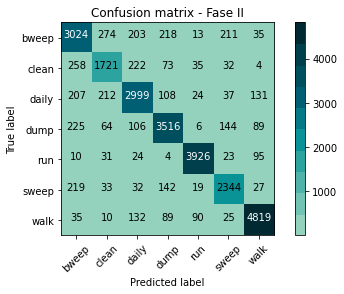

In [ ]:
cnf_matrix = confusion_matrix(trues, predictions, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(trues, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - Fase II')

### 2. Variação das probabilidades

In [ ]:
copyX_test = X_test
copyY_test = y_test

In [ ]:
# tempo de execução médio do código: 5 minutos
accuracys = []
FPs = []
FNs = []

for i in np.arange(0.1, 1, 0.1):
  labels = df_shuffled["label"].unique().tolist()

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  newYtest = []

  formerLabel = 0
  formerPrediction = 0

  lock = 0

  initialRandomLabel = random.choice(labels) # Label aleatória inicial

  positionsInitialCopyYTest = np.where(copyY_test == initialRandomLabel) # Todas as posições em que a label inicial aparece
  positionsCurrentCopyYTest = positionsInitialCopyYTest

  initialPositionLabel = copyY_test[random.choice(positionsInitialCopyYTest[0])] # Posição aleatória em que a label inicial aparece, essa posição tambem valera para a primeira amostra
  currentRandomLabel = initialRandomLabel # label atual, no inicio da analise a label inicial é a label atual 

  positionsLabelsHistoric = []


  initialPrediction = knn.predict(copyX_test[initialPositionLabel].reshape(1, -1)) # predição da linha inicial da analise
  currentPrediction = initialPrediction

  positionsLabelsHistoric.append(initialPositionLabel)

  random.seed(random.randint(1, 10000))
  # loop da analise que ira iterar cada amostra do conjunto de amostras
  while True:
    if (FP + TP + TN + FN) == len(copyX_test):
      break
    else:
      randomNumber = random.random()

      # Analisando nova amostra da mesma atividade 
      if randomNumber > i:
        NewPositionSameLabel()

        if positions == []:
          newPredictionSameLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            TP = TP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)
          else:
            FN = FN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(0)

      # Analise de uma nova amostra de atividade diferente
      if randomNumber < i:
        # armazenando a antiga label e removendo a mesma temporariamente do array de labels
        formerLabel = currentRandomLabel
        labels.remove(formerLabel)

        # Randomizando uma nova label
        currentRandomLabel = random.choice(labels)
        # NDArray com as posições da nova label e randomização da posição aleatoria
        positionsCurrentCopyYTest = np.where(copyY_test == currentRandomLabel)

        NewPositionSameLabel()

        if positions == []:
          newPredictionNewLabel()
        else:
          newPositionLabel = random.choice(positions)
          positionsLabelsHistoric.append(newPositionLabel)

          formerPrediction = currentPrediction

          currentPrediction = knn.predict(copyX_test[newPositionLabel].reshape(1, -1))
          if currentPrediction == formerPrediction:
            FP = FP + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)
          else:
            TN = TN + 1
            trues.append(formerPrediction[0])
            predictions.append(currentPrediction[0])
            newYtest.append(1)

          # devolvendo a label antiga ao array de labels
          labels.append(formerLabel)

  accuracy = (TP + TN)/(TP + TN + FP + FN)
  accuracys.append(accuracy)
  FPs.append(FP)
  FNs.append(FN)

In [ ]:
accuracys

[0.8487841945288754,
 0.8700607902735562,
 0.8822188449848024,
 0.8894376899696048,
 0.9053951367781155,
 0.9209726443768997,
 0.9411094224924013,
 0.9407294832826748,
 0.9616261398176292]

Text(0, 0.5, 'FPs')

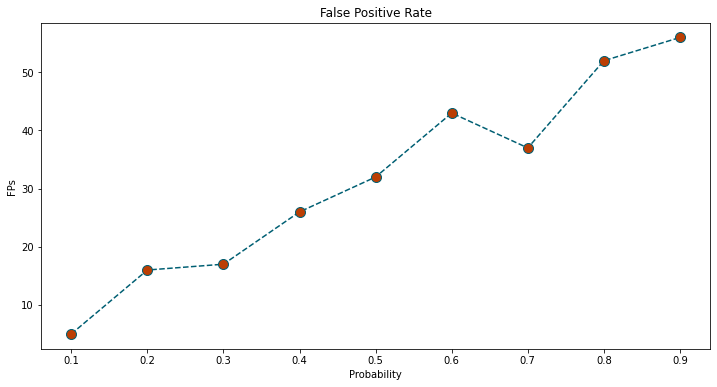

In [ ]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), FPs, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('False Positive Rate')  
plt.xlabel('Probability')  
plt.ylabel('FPs') 

Text(0, 0.5, 'FNs')

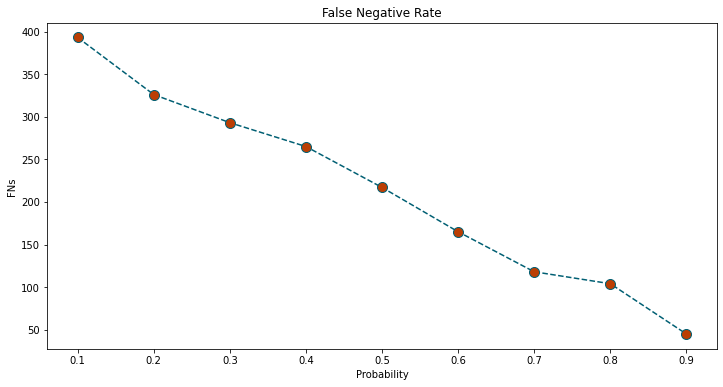

In [ ]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), FNs, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('False Negative Rate')  
plt.xlabel('Probability')  
plt.ylabel('FNs') 

Text(0, 0.5, 'Accuracy')

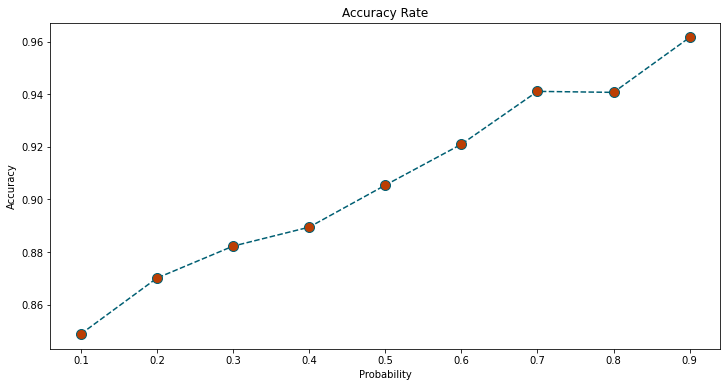

In [ ]:
plt.figure(figsize=(12, 6))  
plt.plot(np.arange(0.1, 1, 0.1), accuracys, color='#005f73', linestyle='dashed', marker='o',  
         markerfacecolor='#bb3e03', markersize=10)
plt.title('Accuracy Rate')  
plt.xlabel('Probability')  
plt.ylabel('Accuracy') 

# Regressão Logistica

In [ ]:
LR = LogisticRegression(solver='saga',multi_class='multinomial').fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
yhat = LR.predict(X_test)
yhat

array([5, 2, 6, ..., 5, 5, 2], dtype=int8)

In [ ]:
f1_score(y_test, yhat, average='weighted') 

0.6991044534268159

In [ ]:
print("Accuracy Test:",metrics.accuracy_score(y_test, yhat))
#print("Precision Test:",metrics.precision_score(y_test, yhat))

Accuracy Test: 0.7040273556231003


In [ ]:
y_proba = LR.predict_proba(X_test)

In [ ]:
y_proba[0]

array([1.77e-01, 3.08e-03, 1.22e-03, 1.80e-02, 5.64e-06, 7.96e-01,
       5.01e-03])

In [ ]:
labels = df_shuffled["label"].unique()
labels.sort()

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       354
           1       0.64      0.59      0.61       384
           2       0.66      0.65      0.65       402
           3       0.73      0.66      0.69       379
           4       0.94      0.87      0.90       377
           5       0.76      0.83      0.80       375
           6       0.62      0.90      0.74       361

    accuracy                           0.70      2632
   macro avg       0.71      0.70      0.70      2632
weighted avg       0.71      0.70      0.70      2632

Confusion matrix, without normalization
[[151  48  35  24   2  67  27]
 [ 25 228  46  46   8  13  18]
 [ 24  51 261   4   5   2  55]
 [ 23  21   8 250   0  15  62]
 [  0   2  26   2 327   0  20]
 [ 29   4   1  16   0 312  13]
 [  4   5  20   2   6   0 324]]


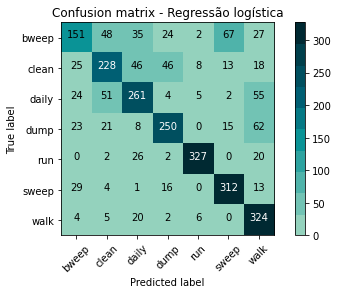

In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - Regressão logística')

In [ ]:
num_folds = 5
scores = cross_val_score(LR, X_train, y_train, cv = num_folds)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
scores

array([0.68, 0.7 , 0.69, 0.7 , 0.69])

In [ ]:
for v in scores:
  print(v)

0.6840390879478827
0.6995114006514658
0.6881107491856677
0.7043973941368078
0.6854115729421353


In [ ]:
stdevCross = scores.std()
stdevCross

0.008143635359677267

#SVM

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [ ]:
yhat = clf.predict(X_test)
yhat 

array([5, 2, 2, ..., 0, 5, 4], dtype=int8)

In [ ]:
f1_score(y_test, yhat, average='weighted') 

0.8916518032276997

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, yhat))

Accuracy: 0.89209726443769


              precision    recall  f1-score   support

           0       0.85      0.76      0.80       354
           1       0.86      0.90      0.88       384
           2       0.92      0.87      0.90       402
           3       0.90      0.88      0.89       379
           4       0.98      0.94      0.96       377
           5       0.90      0.93      0.91       375
           6       0.83      0.96      0.89       361

    accuracy                           0.89      2632
   macro avg       0.89      0.89      0.89      2632
weighted avg       0.89      0.89      0.89      2632

Confusion matrix, without normalization
[[269  23   8  14   2  21  17]
 [ 17 346   5   8   1   7   0]
 [ 10  20 351   7   2   2  10]
 [  6   3   5 332   0   9  24]
 [  2   6   0   1 356   0  12]
 [ 13   2   1   5   0 347   7]
 [  0   0  10   2   2   0 347]]


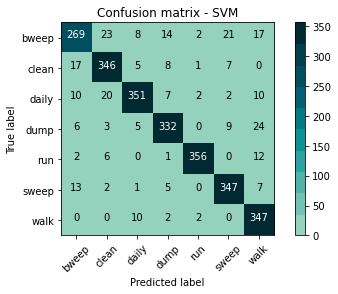

In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=labels.tolist())
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelsName.tolist(),normalize= False,  title='Confusion matrix - SVM')

In [ ]:
num_folds = 5
scores = cross_val_score(clf, X_train, y_train, cv = num_folds)

In [ ]:
scores

array([0.87, 0.88, 0.87, 0.88, 0.86])

In [ ]:
for v in scores:
  print(v)

0.8656351791530945
0.8827361563517915
0.8729641693811075
0.8786644951140065
0.8590057049714751


In [ ]:
stdevCross = scores.std()
stdevCross

0.008599710391763125

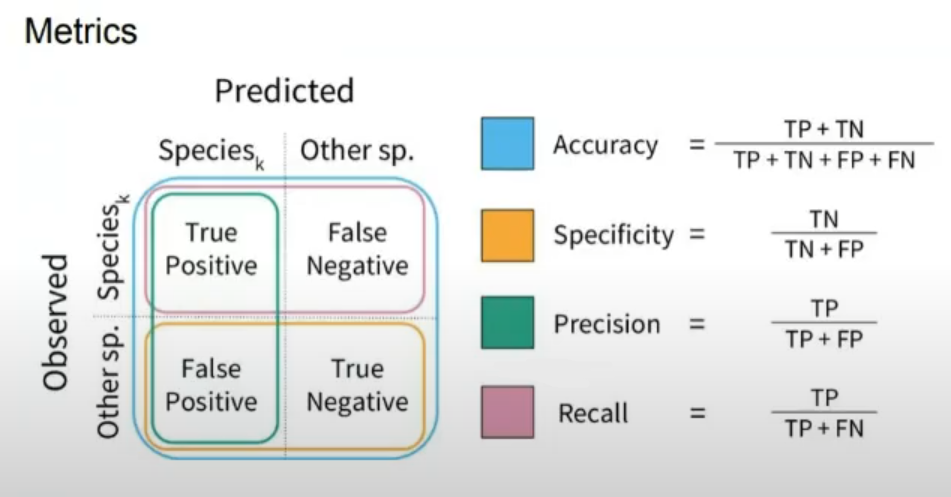